Ahmet Alperen Gungor, 28847
Elifnur Ozturk, 28857 
Ayse Sena Acar, 29506
Baris Bakirdoven, 29028

In [ ]:
import random
import numpy as np
from matplotlib import pyplot 
from keras.datasets import cifar10
import tensorflow.keras as K
import tensorflow as tf

random.seed(42)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model

        :param X: numpy.ndarray of shape (m, 32, 32, 3)
            containing the CIFAR 10 data, where m is the
            number of data points

        :param Y: numpy.ndarray of shape (m,) containing
            the CIFAR 10 labels for X

        :returns: X_p, Y_p
    """
    X_p = K.applications.densenet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [ ]:
# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# input tensor
inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                  160,
                                                                  160,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:

base_model = tf.keras.applications.ResNet50(weights="imagenet", input_shape = (224,224,3), include_top = False)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
def new_model(base_model, img_shape = (224,224,3)):
    
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=img_shape) 
    
    # Forward pass to get the output of the last pooling layer
    X = base_model(inputs)

    #Flatten the output
    X = tf.keras.layers.Flatten()(X)
    
    # Define the new binary classification head 
    
    X = tf.keras.layers.Dense(10, activation='softmax')(X)
        
    outputs = X
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [ ]:
model = new_model(base_model)
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'
optimizer = K.optimizers.Adam()

# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# input tensor
inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                  224,
                                                                  224,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

# load base model
base_model = K.applications.ResNet50(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(224,224,3),
                                        pooling='max')



# add top layers
out = base_model.output
out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(256, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

# callbacks
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))

# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# train
model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_test, y_test))

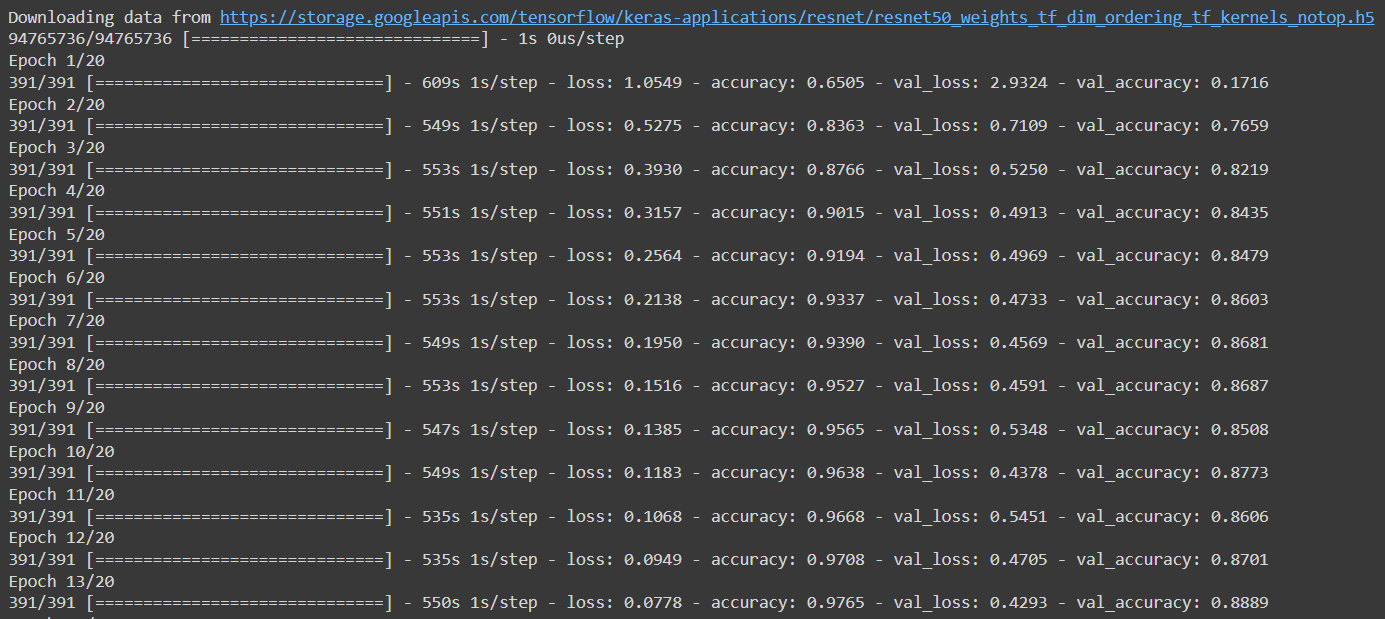